# Notebook to simulate the results of the paper "Constrained proteome allocation affects coexistence in models of competitive microbial communities" by Pacciani-Mori et al. (2021)

Plot and initialization are made with Python, while the simualtion, performed with Euler method, is implemented in Fortran.

Time independent parameters
---------------------------

$N_T$ : int total simulation time 

dt : float time interval for time discretization 

T : float total simualtion time in units of dt (=dt*$N_T$)

$N_S$ : int number of species

$N_R$ : int number of resources

$k^n$ : float vector of dimenstion $N_R$. The nutirtional capacity, which measures how much protein biomass is produced per unit ribosomial mass per unit time

$k^t$ : float vector of dimension $N_S$. The translational capacity, which measures how much protein biomass is produced per unit ribosomial mass per unit time

$\gamma$ : float matrix of dimension $N_S x N_R$. It is defined as $\gamma_{\sigma,i}=k^n_{i}/k^t{\sigma}$

$\rho$ : float vector of dimension $N_S$. This is the conversion factor, equal to the ratio between the total mass of the ribosomial proteins and the total RNA mass of the cells

$\eta$ : float matrix of dimensions $N_S x N_R$. It is defined as $\eta_{\sigma,i}=k^n_i/\rho_{\sigma}$

q : float vector of dimension $N_S$. It is the maintainance cost of the species

s : float vector of  dimension $N_R$. Resources supply rate in the system

$\xi$ : float vector of dimension $N_R$. This is the maximum catalytic rate of the enzyme used to metabolize resources

K : float vector of dimension $N_R$. This is the half saturation constant which enters in the monod function

$\tau$ : float vector of dimension $N_S$. These are the cahracteristic timescales of the adaptive process that maximes the growth rate in the dynamics of the proteome allocation $\varphi$

$\Phi$ : float vector of dimension $N_S$. Total proteome fraction allocated by species for growth and metabolism 

$\theta$ : given constant independent on the species

Dynamical variables
-------------------

m : vector of dimensions $N_S$. Biomass density of species at time t

c : vector of dimensions $N_R$. Concentration of resources at time t

$\varphi$ : matrix of dimensions $N_S x N_R$. Fraction of proteome allocate by species to uptake resources at time t

Rescaled variables
------------------

$\hat{s}$ : vector of dimension $N_R$. Rescaled supply rate

$\hat{\varphi}$ : three index tensor. Resclaed metabolic strategies at time t

z : vector of dimension $N_S$. Positive coefficients that sum to 1

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import animation
import progressbar
import subprocess
import time
from time import sleep
import pickle as pk
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import sys
from subroutines import monod
import math
import os
from gtts import gTTS



In [2]:
########### Install Fortran Program for time simulation ###########

subprocess.call("gfortran -O3 code/modules.f95 code/debugging.f95 -o debugging.out -llapack -lfftw3 -lm",shell=True)
subprocess.call("gfortran -O3 code/modules.f95 code/main.f95 -o main.out -llapack -lfftw3 -lm",shell=True)




0

# Prameters for the first figures of the paper



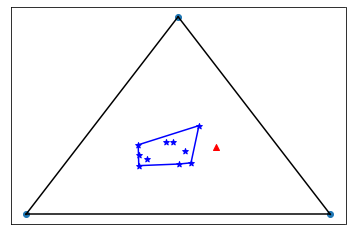

In [2]:
########### Parameters insertion ###########

### Insert number of species N_S and number of resources N_R

N_S=10
N_R=3
dt=0.00001

count=0		#error counter
threshold=0.001	#threshold to check  constraints



N_T=int(2000/dt) #number of time iterations
T=dt*N_T

### Seed


seed=17 # coex, 5, 40 non coex
np.random.seed(seed)
s=np.random.uniform(0.5*10**4,10**4,N_R)	#constant resource injection rate
np.random.seed(1)


#fig5 >> seed: 5 non coex, 28 coex, phi = U(1,10)
#fig6 >> seed: 1  non ceox at the beginning

###New simulations
#Fig5 >> 1 ext, 16 coex, dt=0.0001
#Fig6 >> 17 for s, 1 for the rest, phi =U(1,3) dt=0.00001


### Multiplicative factor

x = 1.0 #parameter of figure 6, to rescale supply rate

y = 1.0

########### Variables initialization: Fig. 5 ###########

filename = "Fig6.png"
### Time independent variables
k_n = np.random.uniform(5.0,10.0,N_R)	#nutritional capacity
k_t = np.random.uniform(1.0, 5.0,N_S)	#translational capacity 
gamma = np.outer(1.0/k_t,k_n) 	#ratio between nutritional capacity and translational capacity
rho = np.random.uniform(0.6,0.8,N_S)	#conversion factor
eta = np.outer(1.0/rho,k_n)		#eta parameter
s = s*x
xi = np.random.uniform(10**3,1.5*10**3,N_R) 	#maximum catalytic rate
K = np.random.uniform(5.0*10**2,10**3,N_R) 	#half saturation constant
tau = np.random.uniform(1.0*10**4,5.0*10**4,N_S) 	#characteristic timescale of adaptive process
tau = y*tau
PHI = np.random.uniform(0.45,0.55,N_S)	#total proteome fraction for growth and metabolism
theta = 5.0
q = PHI/(rho*(theta*np.ones(N_S)+1.0/k_t))	#death rate definition to have coexistence at stationarity 


### Initialization of the dynamical variables
m = np.random.uniform(1.0,5.0,N_S)	#species at time 0
c = np.random.uniform(0.5*10**4,1.5*10**4,N_R)	#resources at time 0
phi = np.random.uniform(1.0,3.0,(N_S,N_R))            #proteome fraction for growth and met

### Renormalize phi to meet the constraints for having a total proteome allocation fixed
v_new = np.ones((N_S,N_R))+gamma*np.outer(np.ones(N_S),monod(c,K))
phi = phi*np.outer(PHI,np.ones(N_R))/np.outer(np.diag(np.dot(phi,np.transpose(v_new))),np.ones(N_R))

### Rescaled variables
s_hat = s*k_n*(1.0/np.dot(s*k_n,1.0/xi))/xi
phi_hat_init = np.copy(phi)	#defined here as this to match dimensions
phi_hat_init = phi/np.outer(np.dot(phi,np.ones(N_R)),np.ones(N_R))
z = m*rho*q/np.dot(m*rho*q,np.ones(N_S))

def check_constraint(threshold,count,c,phi):
    """
    
    This function check if the constraint of total proteom allocation is satisfied
    
    Parameters
    ----------
    t : int simulation time
    sigma : species index
    
    Returns
    -------
    The difference between the expected total proteome fraction and the computed
    
    """
    d_sum = 0.0
    int_count = 0
    for sigma in range(N_S):
       v_sigma_1 = np.ones(N_R)+gamma[sigma]*monod(c,K)
       distance = (np.dot(phi[sigma],v_sigma_1)-PHI[sigma])**2
       d_sum=d_sum+distance
       if distance>threshold:
          int_count=int_count+1
       
    if int_count>0:
        #print("ERROR: total proteome fraction constraint not satisfied \n")
        count = count+1
        #sys.exit()
    return d_sum,count
    
def check_norm(vector, threshold,count):
    summation = np.sum(vector)
    if((summation-1)**2>threshold):
       count=count+1
    

########### Check initial conditions and stop program if not satisfied ###########
### S_hat
check_norm(s_hat,threshold,count)
if(count>0):
   print("ERROR: s_hat not normalized")
   sys.exit()

### phi_hat
for i in range(N_S):
   check_norm(phi_hat_init[i],threshold,count)
   if(count>0):
      print("ERROR: phi_hat not normalized")
      sys.exit()
 
### z  
check_norm(z,threshold,count)
if(count>0):
   print("ERROR: phi_hat not normalized")
   sys.exit()
   
### Proteome constraint
d_sum,count = check_constraint(threshold,count,c,phi)
if(count>0):
   print("ERROR: proteome constraint not satisfied")
   sys.exit()


########### Variable printing in files for fortran code ###########
f = open("temp/parameters.txt",'w')
f.write(str(N_S)+"\n")
f.write(str(N_R)+"\n")
f.write(str(N_T)+"\n")
f.write(str(dt)+"\n")
f.write(str(threshold)+"\n")
f.write(str(theta)+"\n")
f.close()

f = open("temp/stat_var.txt",'w')
np.savetxt(f,k_n, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,k_t, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,np.reshape(gamma,(N_S*N_R,1),order='A'), delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,rho, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,np.reshape(eta,(N_S*N_R,1),order='A'), delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,xi, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,K, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,PHI, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,q, delimiter=" ",newline=' ')
f.write("\n")
f.close()

f = open("temp/s.txt", 'w')
np.savetxt(f,s, delimiter=" ",newline=' ')
f.close()

f = open("temp/tau.txt", 'w')
np.savetxt(f,tau, delimiter=" ",newline=' ')
f.close()

f = open("temp/dyn_var.txt",'w')
np.savetxt(f,m, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,c, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,np.reshape(phi,(N_S*N_R,1),order='A'), delimiter=" ",newline=' ')
f.write("\n")
f.close()

########### Convex hull to check coexistence ###########    
    
### 2d symplex   
vertexes = np.array([[0.0,1.0],[math.sqrt(3)/2,-0.5],[-math.sqrt(3)/2,-0.5]])   
vertexes_hull = ConvexHull(vertexes)   
plt.plot(vertexes[:,0], vertexes[:,1], 'o')
plt.xticks([])
plt.yticks([])
for simplex in vertexes_hull.simplices:
    plt.plot(vertexes[simplex, 0], vertexes[simplex, 1], 'k-')    
    
  
    
supply_rate = np.dot(s_hat,vertexes) 
plt.scatter(supply_rate[0],supply_rate[1],c='red',marker='^')    


prot_frac = np.dot(phi_hat_init,vertexes)

prot_hull = ConvexHull(prot_frac)
plt.scatter(prot_frac[:,0], prot_frac[:,1], c='b', marker='*')
for simplex in prot_hull.simplices:
    plt.plot(prot_frac[simplex, 0], prot_frac[simplex, 1], c='b')    

plt.show()    

In [ ]:
########### Time evolution ###########

start = time.time()
subpro = subprocess.run("./main.out",stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf-8")   
type(subpro.stdout)
print(subpro.stdout)
stop = time.time()
print("Total simulation time: "+str((stop-start)))

########### Load simulation ###########   
    
m_dyn = np.loadtxt("data/species.txt")    
c_dyn = np.loadtxt("data/resources.txt")
phi_final = np.loadtxt("data/proteome.txt")[-1]  
phi_final = np.reshape(phi_final,(N_S,N_R))
square_diff = np.loadtxt("data/square_diff.txt")
time_s = np.loadtxt("data/time.txt")

########### Plotting ###########

### Plot configuration
fig, ax = plt.subplots(1,2,figsize=(12, 4))
fig2, ax2 = plt.subplots(1,2, figsize=(12,4))
ax[0].set_yscale("log")
ax[0].set(xlabel='t(hours)',ylabel='m(t) ($\mu$ g/ mL)')
ax2[0].set_yscale("log")
ax2[0].set(xlabel='t(hours)',ylabel='c(t)')
ax[1].set_xticks([])
ax[1].set_yticks([])


### Resources dynamics plots
for sigma in range(N_R):
   ax2[0].plot(time_s,c_dyn[:,sigma])

ax2[1].plot(time_s,square_diff)


### Species dynamics plot
for sigma in range(N_S):
   ax[0].plot(time_s,m_dyn[:,sigma])





### Convex hull plotting

### 2d symplex

vertexes_hull=ConvexHull(vertexes)   
ax[1].plot(vertexes[:,0], vertexes[:,1], 'o')
for simplex in vertexes_hull.simplices:
    ax[1].plot(vertexes[simplex, 0], vertexes[simplex, 1], 'k-')    
    
  
### Supply rate    
supply_rate=np.dot(s_hat,vertexes) 
ax[1].scatter(supply_rate[0],supply_rate[1], c='green',marker='^')    

### Proteome fraction convex hull plotting at t=0
prot_frac_i=np.dot(phi_hat_init,vertexes)
prot_hull_i=ConvexHull(prot_frac_i)
ax[1].scatter(prot_frac_i[:,0], prot_frac_i[:,1], c='b', marker='*')
for simplex in prot_hull_i.simplices:
    ax[1].plot(prot_frac_i[simplex, 0], prot_frac_i[simplex, 1], c='b')    

### Proteome fraction convex hull plotting at t=N_T
phi_hat_final=np.copy(phi_final)	#defined here as this to match dimensions
phi_hat_final=phi_final/np.outer(np.dot(phi_final,np.ones(N_R)),np.ones(N_R))
prot_frac_f=np.dot(phi_hat_final,vertexes)
prot_hull_f=ConvexHull(prot_frac_f)
ax[1].scatter(prot_frac_f[:,0], prot_frac_f[:,1], c='red', marker='o')
for simplex in prot_hull_f.simplices:
    ax[1].plot(prot_frac_f[simplex, 0], prot_frac_f[simplex, 1], c='red')    

fig.savefig(filename)
plt.show()

Total simulation time: 2913.7349603176117


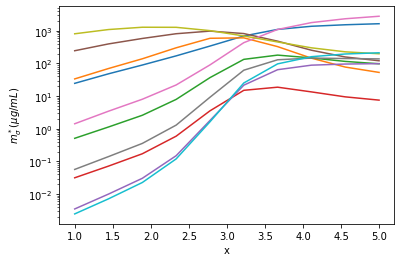

In [18]:
### Second plot figure 6

m_eq = []
vec_x = np.linspace(1,5,10)
start = time.time()
for x in vec_x:
    
    ### Update s
    f = open("temp/s.txt",'w')
    np.savetxt(f,s*x, delimiter=" ",newline=' ')
    f.close()
    
    ### Time evolution
    subprocess.call("./main.out", shell=True)
    m_eq.append(np.loadtxt("data/species.txt")[-1])
    
stop=time.time()
print("Total simulation time: "+str((stop-start)))




Total simulation time: 968.7293176651001


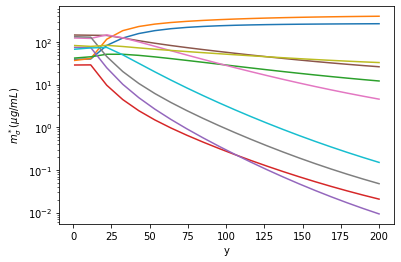

In [37]:
### Second plot figure 7
m_eq = []
vec_y = np.linspace(1,200,20)
start=time.time()
for y in vec_y:
    
    ### Update tau
    f=open("temp/tau.txt",'w')
    np.savetxt(f,tau*y, delimiter=" ",newline=' ')
   
    ### Time evolution
    subprocess.call("./main.out", shell=True)
    m_eq.append(np.loadtxt("data/species.txt")[-1])
    
stop=time.time()
print("Total simulation time: "+str((stop-start)))

### Plot
fig, ax = plt.subplots(1,figsize=(6,4))
ax.set_yscale("log")
ax.set(xlabel = "y", ylabel = "$m^*_{\sigma}(\mu g/ mL)$")
ax.plot(vec_y,m_eq)
plt.show()
fig.savefig("Fig7_second.png")

# Diauxic Shifts

In [5]:
########### Parameters insertion ###########

### Insert number of species N_S and number of resources N_R

N_S=1
N_R=2
dt=0.00005

count=0		#error counter
threshold=0.001	#threshold to check  constraints



N_T=int(25/dt) #number of time iterations
T=dt*N_T



########### Variables initialization: Fig. 5 ###########

filename = "Fig_diauxic_shifts.png"
### Time independent variables
k_n = np.array([1.0,0.25])	#nutritional capacity
k_t = np.array([4.5])	#translational capacity 
gamma = np.outer(1.0/k_t,k_n) 	#ratio between nutritional capacity and translational capacity
rho = np.array([0.6])	#conversion factor
eta = np.outer(1.0/rho,k_n)		#eta parameter
s = np.zeros(N_R)	#constant resource injection rate
xi = np.array([1000,100])  	#maximum catalytic rate
K = np.array([1000,500]) 	#half saturation constant
tau = np.array([1]) 	#characteristic timescale of adaptive process
tau = y*tau
PHI = np.array([0.55])	#total proteome fraction for growth and metabolism
theta = 100.0
q = PHI/(rho*(theta*np.ones(N_S)+1.0/k_t))	#death rate definition to have coexistence at stationarity 


### Initialization of the dynamical variables
m = 2.5*np.ones(N_S)	#species at time 0
c = 10**4*np.ones(N_R)	#resources at time 0
phi = np.ones((N_S,N_R))            #proteome fraction for growth and met

### Renormalize phi to meet the constraints for having a total proteome allocation fixed
v_new = np.ones((N_S,N_R))+gamma*np.outer(np.ones(N_S),monod(c,K))
phi = phi*np.outer(PHI,np.ones(N_R))/np.outer(np.diag(np.dot(phi,np.transpose(v_new))),np.ones(N_R))

phi_hat_init = np.copy(phi)	#defined here as this to match dimensions
phi_hat_init = phi/np.outer(np.dot(phi,np.ones(N_R)),np.ones(N_R))

def check_constraint(threshold,count,c,phi):
    """
    
    This function check if the constraint of total proteom allocation is satisfied
    
    Parameters
    ----------
    t : int simulation time
    sigma : species index
    
    Returns
    -------
    The difference between the expected total proteome fraction and the computed
    
    """
    d_sum = 0.0
    int_count = 0
    for sigma in range(N_S):
       v_sigma_1 = np.ones(N_R)+gamma[sigma]*monod(c,K)
       distance = (np.dot(phi[sigma],v_sigma_1)-PHI[sigma])**2
       d_sum=d_sum+distance
       if distance>threshold:
          int_count=int_count+1
       
    if int_count>0:
        #print("ERROR: total proteome fraction constraint not satisfied \n")
        count = count+1
        #sys.exit()
    return d_sum,count
    
def check_norm(vector, threshold,count):
    summation = np.sum(vector)
    if((summation-1)**2>threshold):
       count=count+1
    

########### Check initial conditions and stop program if not satisfied ###########
### S_hat
check_norm(s_hat,threshold,count)
if(count>0):
   print("ERROR: s_hat not normalized")
   sys.exit()

### phi_hat
for i in range(N_S):
   check_norm(phi_hat_init[i],threshold,count)
   if(count>0):
      print("ERROR: phi_hat not normalized")
      sys.exit()
 
### z  
check_norm(z,threshold,count)
if(count>0):
   print("ERROR: phi_hat not normalized")
   sys.exit()
   
### Proteome constraint
d_sum,count = check_constraint(threshold,count,c,phi)
if(count>0):
   print("ERROR: proteome constraint not satisfied")
   sys.exit()


########### Variable printing in files for fortran code ###########
f = open("temp/parameters.txt",'w')
f.write(str(N_S)+"\n")
f.write(str(N_R)+"\n")
f.write(str(N_T)+"\n")
f.write(str(dt)+"\n")
f.write(str(threshold)+"\n")
f.write(str(theta)+"\n")
f.close()

f = open("temp/stat_var.txt",'w')
np.savetxt(f,k_n, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,k_t, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,np.reshape(gamma,(N_S*N_R,1),order='A'), delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,rho, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,np.reshape(eta,(N_S*N_R,1),order='A'), delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,xi, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,K, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,PHI, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,q, delimiter=" ",newline=' ')
f.write("\n")
f.close()

f = open("temp/s.txt", 'w')
np.savetxt(f,s, delimiter=" ",newline=' ')
f.close()

f = open("temp/tau.txt", 'w')
np.savetxt(f,tau, delimiter=" ",newline=' ')
f.close()

f = open("temp/dyn_var.txt",'w')
np.savetxt(f,m, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,c, delimiter=" ",newline=' ')
f.write("\n")
np.savetxt(f,np.reshape(phi,(N_S*N_R,1),order='A'), delimiter=" ",newline=' ')
f.write("\n")
f.close()


NameError: name 'y' is not defined

 Total number of errors:                                        0

Total simulation time: 0.5090763568878174


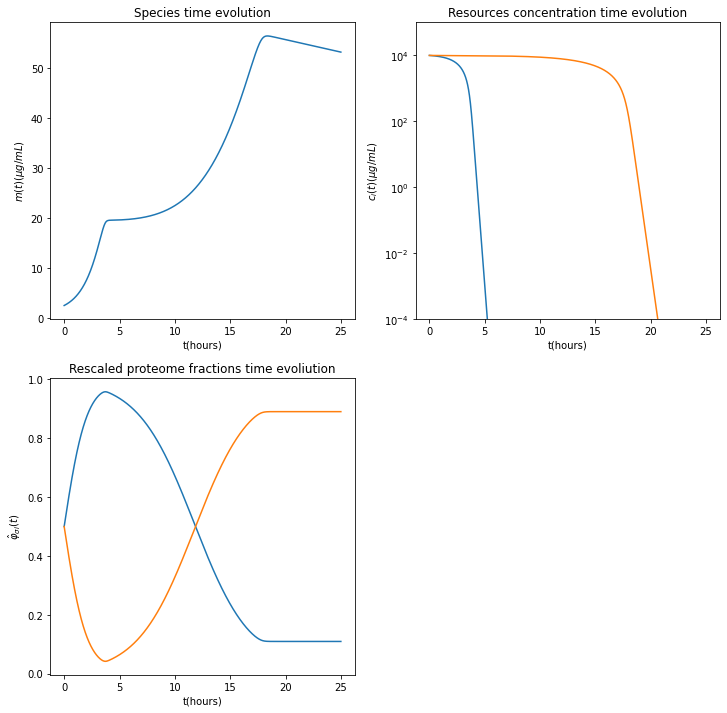

In [24]:
########### Time evolution ###########

start = time.time()
subpro = subprocess.run("./main.out",stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding="utf-8")   
type(subpro.stdout)
print(subpro.stdout)
stop = time.time()
print("Total simulation time: "+str((stop-start)))

########### Load simulation ###########   
    
m_dyn = np.loadtxt("data/species.txt")    
c_dyn = np.loadtxt("data/resources.txt")
phi_dyn = np.loadtxt("data/proteome.txt")
square_diff = np.loadtxt("data/square_diff.txt")
time_s = np.loadtxt("data/time.txt")

### Rescale phi to plot
phi_dyn_hat = np.copy(phi_dyn)
for t in range(len(time_s)):
    phi_dyn_hat[t] = phi_dyn[t]/np.outer(np.dot(phi_dyn[t],np.ones(N_R)),np.ones(N_R))

########### Plotting ###########

### Plot configuration
fig, ax = plt.subplots(2,2,figsize=(12, 12))
ax[0,0].set(xlabel='t(hours)',ylabel='$m(t) (\mu g/ mL)$')
ax[0,0].set_title("Species time evolution")
ax[0,1].set_yscale('log')
ax[0,1].set_ylim(10**(-4),10**5)
ax[0,1].set_title("Resources concentration time evolution")
ax[0,1].set(xlabel='t(hours)',ylabel='$c_i(t)(\mu g/ mL)$')
ax[1,0].set(xlabel='t(hours)', ylabel='$\hat{\\varphi}_{\sigma i}(t)$')
ax[1,0].set_title("Rescaled proteome fractions time evoliution")
fig.delaxes(ax[1,1])
### Species dynamics plot

ax[0,0].plot(time_s,m_dyn)


### Resources dynamics plots
for i in range(N_R):
   ax[0,1].plot(time_s,c_dyn[:,i])

### Resclaed proteome fractions plot

for i in range(N_R):
    ax[1,0].plot(time_s, phi_dyn_hat[:,i])


fig.savefig(filename)
plt.show()